# Carry and momentum in the Brazilian yield curve

### Libraries

In [1]:
import sys
sys.path.insert(1, 'C:/Users/ddarin/FinanceHub')

import pandas as pd
import numpy as np
from dataapi import DBConnect, SGS
from portfolio.performance import Performance as FHP
fhp = FHP()
import matplotlib.pyplot as plt
from calendars import DayCounts
from tqdm import tqdm
%matplotlib inline

### DIs contracts data
[Financehub](https://github.com/Finance-Hub/) AWS server.

In [2]:
dbc = DBConnect(username='fhreadonly', password='finquant')
query = "select * from \"B3futures\" where contract='DI1'"
df = pd.read_sql(query, dbc.connection)
df.tail(10)

,time_stamp,contract,maturity_code,open_interest_open,open_interest_close,number_of_trades,trading_volume,financial_volume,previous_settlement,indexed_settlement,opening_price,minimum_price,maximum_price,average_price,last_price,settlement_price,last_bid,last_offer
150498,2020-05-15,DI1,N25,11145,11145,49,455,32126951,70570.16,70825.46,7.04,7.03,7.12,7.051,7.10,70817.43,0.00,7.38
150499,2020-05-15,DI1,F26,71438,71438,134,1005,67444209,66976.28,67171.02,7.39,7.28,7.42,7.345,7.37,67163.40,7.32,0.00
150500,2020-05-15,DI1,N26,9425,9425,13,125,7991530,63829.45,64047.82,7.59,7.59,7.60,7.594,7.59,64040.56,0.00,0.00
150501,2020-05-15,DI1,F27,388313,388313,3186,33825,2053672777,60517.49,60759.03,7.93,7.75,7.95,7.830,7.87,60752.14,7.86,7.90
150502,2020-05-15,DI1,F28,25475,25475,43,240,13156569,54553.74,54705.47,8.25,8.12,8.26,8.213,8.25,54699.27,0.00,0.00
150503,2020-05-15,DI1,F29,201417,201417,1439,13170,654038139,49635.17,49690.60,8.54,8.40,8.59,8.476,8.54,49684.97,8.51,8.54
150504,2020-05-15,DI1,F30,9045,9045,0,0,0,45002.15,45096.58,0.00,0.00,0.00,0.000,0.00,45091.47,0.00,0.00
150505,2020-05-15,DI1,F31,31253,31253,117,815,33126958,40695.92,40828.74,8.86,8.80,8.92,8.864,8.88,40824.11,8.00,9.30
150506,2020-05-15,DI1,F33,20,20,0,0,0,33581.40,33709.63,0.00,0.00,0.00,0.000,0.00,33705.81,0.00,0.00
150507,2020-05-15,DI1,F35,0,0,0,0,0,27761.00,27882.22,0.00,0.00,0.00,0.000,0.00,27879.06,0.00,0.00


### Business days to maturity calculation

In [3]:
df['time_stamp'] = pd.to_datetime(df['time_stamp'])

mat_dict = {'01': 'F',
            '02': 'G',
            '03': 'H',
            '04': 'J',
            '05': 'K',
            '06': 'M',
            '07': 'N',
            '08': 'Q',
            '09': 'U',
            '10': 'V',
            '11': 'X',
            '12': 'Z'}

mat_dict = {v: k for k, v in mat_dict.items()}

mat_month = df['maturity_code'].str[0].map(mat_dict)

def convert_year(year2digits):
    
    if int(year2digits) >= 91:
        year4digits = '19' + year2digits
    else:
        year4digits = '20' + year2digits
    
    return year4digits

mat_year = df['maturity_code'].str[-2:].apply(convert_year)

dates = pd.to_datetime(mat_year + mat_month + '01')

dc = DayCounts('BUS/252', calendar='anbima')
dates = dc.busdateroll(dates, 'following')
dates

df['maturity_date'] = dates

df['DU'] = dc.days(df['time_stamp'], df['maturity_date'])
df = df[df['DU'] >= 0]

# Deletes UPs with value zero
df = df[df.settlement_price != 0]

# Filters Open Interest > 1
df = df[df['trading_volume'] != 0]

df.tail(10)

,time_stamp,contract,maturity_code,open_interest_open,open_interest_close,number_of_trades,trading_volume,financial_volume,previous_settlement,indexed_settlement,opening_price,minimum_price,maximum_price,average_price,last_price,settlement_price,last_bid,last_offer,maturity_date,DU
150495,2020-05-15,DI1,V24,20840,20840,1,425,32053155,75507.42,75796.48,6.67,6.67,6.67,6.670,6.67,75787.89,0.00,0.00,2024-10-01,1101
150496,2020-05-15,DI1,F25,848903,848903,8507,85565,6329350215,73765.02,74072.42,6.82,6.66,6.85,6.738,6.77,74064.02,6.76,6.79,2025-01-02,1165
150497,2020-05-15,DI1,J25,4170,4170,4,105,7602797,72124.90,72407.25,6.89,6.85,6.95,6.861,6.95,72399.04,0.00,0.00,2025-04-01,1226
150498,2020-05-15,DI1,N25,11145,11145,49,455,32126951,70570.16,70825.46,7.04,7.03,7.12,7.051,7.10,70817.43,0.00,7.38,2025-07-01,1287
150499,2020-05-15,DI1,F26,71438,71438,134,1005,67444209,66976.28,67171.02,7.39,7.28,7.42,7.345,7.37,67163.40,7.32,0.00,2026-01-02,1418
150500,2020-05-15,DI1,N26,9425,9425,13,125,7991530,63829.45,64047.82,7.59,7.59,7.60,7.594,7.59,64040.56,0.00,0.00,2026-07-01,1540
150501,2020-05-15,DI1,F27,388313,388313,3186,33825,2053672777,60517.49,60759.03,7.93,7.75,7.95,7.830,7.87,60752.14,7.86,7.90,2027-01-04,1668
150502,2020-05-15,DI1,F28,25475,25475,43,240,13156569,54553.74,54705.47,8.25,8.12,8.26,8.213,8.25,54699.27,0.00,0.00,2028-01-03,1919
150503,2020-05-15,DI1,F29,201417,201417,1439,13170,654038139,49635.17,49690.60,8.54,8.40,8.59,8.476,8.54,49684.97,8.51,8.54,2029-01-02,2168
150505,2020-05-15,DI1,F31,31253,31253,117,815,33126958,40695.92,40828.74,8.86,8.80,8.92,8.864,8.88,40824.11,8.00,9.30,2031-01-02,2671


### One day CDI series
Central Bank of Brazil API, [Sistema Gerenciador de Series](https://www3.bcb.gov.br/sgspub/localizarseries/localizarSeries.do?method=prepararTelaLocalizarSeries).

In [4]:
sgs = SGS()
df_cdi = sgs.fetch({12: 'CDI'})/100
df_cdi.tail(5)

,CDI
data,
2020-12-02,0.000075
2020-12-03,0.000075
2020-12-04,0.000075
2020-12-07,0.000075
2020-12-08,0.000075


In [5]:
# Annualizes CDI rates
cdi_series = pd.Series(((1+df_cdi['CDI'])**(252))-1)

## Building the yield curve
### Calculation of the DIs Unitary Prices

$$
DI_{t}=\left(\frac{100000}{UP_{t}}\right)^{\frac{252}{bus}}-1
$$

In [6]:
df['settlement_rate'] = (100000/df['settlement_price'])**(252/df['DU'])-1 
df

,time_stamp,contract,maturity_code,open_interest_open,open_interest_close,number_of_trades,trading_volume,financial_volume,previous_settlement,indexed_settlement,...,minimum_price,maximum_price,average_price,last_price,settlement_price,last_bid,last_offer,maturity_date,DU,settlement_rate
0,2002-01-18,DI1,G02,148607,149209,9,1757,174492059,99312.60,99381.385,...,18.97,18.99,18.988,18.980,99312.75,0.00,0.00,2002-02-01,10,0.189800
1,2002-01-18,DI1,H02,52086,51504,10,1805,177048159,98084.75,98158.110,...,18.97,19.03,18.991,18.970,98090.32,18.95,19.00,2002-03-01,28,0.189501
2,2002-01-18,DI1,J02,257781,256921,65,6383,617498092,96734.24,96817.414,...,18.93,19.07,19.000,18.930,96750.55,0.00,0.00,2002-04-01,48,0.189377
3,2002-01-18,DI1,K02,27820,28885,7,1310,124780477,95260.80,95357.606,...,19.08,19.19,19.138,19.080,95291.75,18.96,18.98,2002-05-02,70,0.189600
4,2002-01-18,DI1,N02,185409,186747,808,130358,12061140547,92517.23,92628.451,...,19.12,19.40,19.294,19.125,92564.48,0.00,0.00,2002-07-01,111,0.191737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150500,2020-05-15,DI1,N26,9425,9425,13,125,7991530,63829.45,64047.820,...,7.59,7.60,7.594,7.590,64040.56,0.00,0.00,2026-07-01,1540,0.075650
150501,2020-05-15,DI1,F27,388313,388313,3186,33825,2053672777,60517.49,60759.030,...,7.75,7.95,7.830,7.870,60752.14,7.86,7.90,2027-01-04,1668,0.078200
150502,2020-05-15,DI1,F28,25475,25475,43,240,13156569,54553.74,54705.470,...,8.12,8.26,8.213,8.250,54699.27,0.00,0.00,2028-01-03,1919,0.082450
150503,2020-05-15,DI1,F29,201417,201417,1439,13170,654038139,49635.17,49690.600,...,8.40,8.59,8.476,8.540,49684.97,8.51,8.54,2029-01-02,2168,0.084700


In [7]:
# Filters volume > 0
df = df[df['trading_volume'] != 0]
df.tail()

,time_stamp,contract,maturity_code,open_interest_open,open_interest_close,number_of_trades,trading_volume,financial_volume,previous_settlement,indexed_settlement,...,minimum_price,maximum_price,average_price,last_price,settlement_price,last_bid,last_offer,maturity_date,DU,settlement_rate
150500,2020-05-15,DI1,N26,9425,9425,13,125,7991530,63829.45,64047.82,...,7.59,7.60,7.594,7.59,64040.56,0.00,0.00,2026-07-01,1540,0.07565
150501,2020-05-15,DI1,F27,388313,388313,3186,33825,2053672777,60517.49,60759.03,...,7.75,7.95,7.830,7.87,60752.14,7.86,7.90,2027-01-04,1668,0.07820
150502,2020-05-15,DI1,F28,25475,25475,43,240,13156569,54553.74,54705.47,...,8.12,8.26,8.213,8.25,54699.27,0.00,0.00,2028-01-03,1919,0.08245
150503,2020-05-15,DI1,F29,201417,201417,1439,13170,654038139,49635.17,49690.60,...,8.40,8.59,8.476,8.54,49684.97,8.51,8.54,2029-01-02,2168,0.08470
150505,2020-05-15,DI1,F31,31253,31253,117,815,33126958,40695.92,40828.74,...,8.80,8.92,8.864,8.88,40824.11,8.00,9.30,2031-01-02,2671,0.08820


In [8]:
df_yield_curve = pd.pivot_table(df, values='settlement_rate', index=['time_stamp'], columns=['DU'], aggfunc=np.sum)
df_yield_curve

DU,1,2,3,4,5,6,7,8,9,10,...,3676,3691,3692,3693,3694,3695,3696,3698,3717,3755
time_stamp,,,,,,,,,,,,,,,,,,,,,
2002-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1898,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.189901,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.189849,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-23,NaN,NaN,NaN,NaN,NaN,NaN,0.189605,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-24,NaN,NaN,NaN,NaN,NaN,0.190463,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Includes the annualized CDI rates in the DIs DataFrame
df_yield_curve[1] = df_yield_curve[1].fillna(value=cdi_series)
df_yield_curve.tail(10)

DU,1,2,3,4,5,6,7,8,9,10,...,3676,3691,3692,3693,3694,3695,3696,3698,3717,3755
time_stamp,,,,,,,,,,,,,,,,,,,,,
2020-05-04,0.0365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-05,0.0365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-06,0.0365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-07,0.0290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-08,0.0290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-11,0.0290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-12,0.0290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-13,0.0290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-14,0.0290,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Cubic spline

In [10]:
df_yield_curve_int = df_yield_curve.interpolate(method ='cubic', axis=1)
df_yield_curve_int

DU,1,2,3,4,5,6,7,8,9,10,...,3676,3691,3692,3693,3694,3695,3696,3698,3717,3755
time_stamp,,,,,,,,,,,,,,,,,,,,,
2002-01-18,0.190201,0.190144,0.190090,0.190039,0.189992,0.189948,0.189906,0.189868,0.189833,0.189800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-21,0.190300,0.190247,0.190195,0.190143,0.190093,0.190043,0.189994,0.189947,0.189901,0.189856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-22,0.190201,0.190142,0.190085,0.190032,0.189982,0.189935,0.189890,0.189849,0.189810,0.189774,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-23,0.190099,0.189997,0.189903,0.189817,0.189739,0.189668,0.189605,0.189548,0.189498,0.189454,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-24,0.190201,0.190277,0.190340,0.190391,0.190432,0.190463,0.190484,0.190498,0.190503,0.190502,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-11,0.029000,0.029049,0.029090,0.029122,0.029148,0.029166,0.029178,0.029182,0.029180,0.029173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-12,0.029000,0.029028,0.029050,0.029067,0.029079,0.029087,0.029090,0.029089,0.029084,0.029074,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-13,0.029000,0.029030,0.029054,0.029071,0.029083,0.029090,0.029091,0.029088,0.029079,0.029066,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


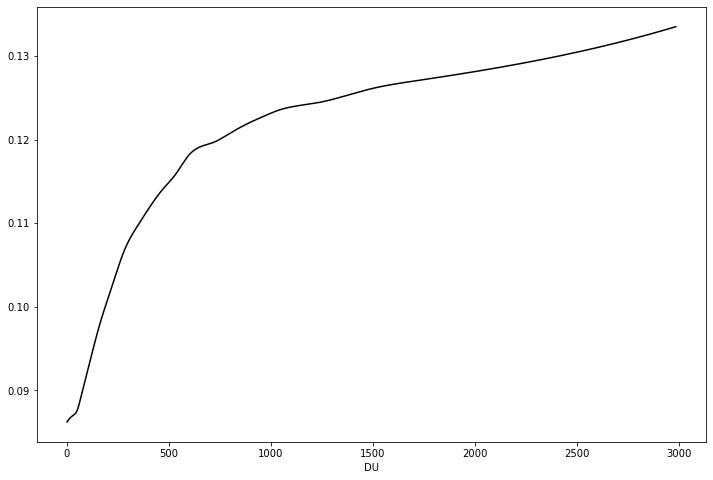

In [11]:
int_plot = df_yield_curve_int.iloc[2000,:]
int_plot.plot(figsize=(12,8), color = 'black')

## MACD

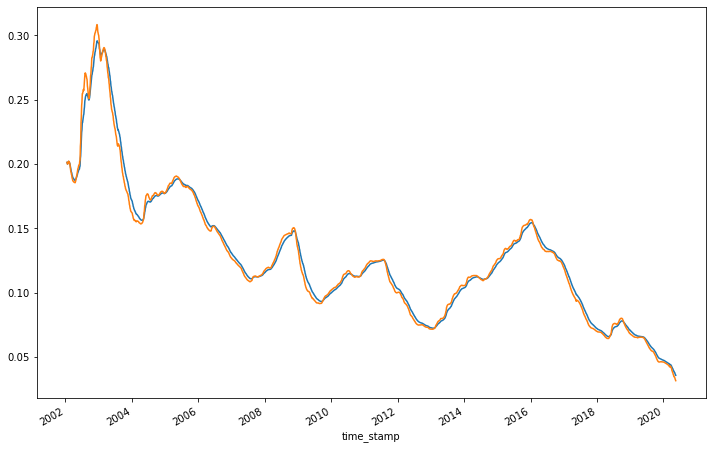

In [12]:
# 252 business days DIs MACD, for observation purpose only
slow_mean = df_yield_curve_int[252].ewm(halflife=26).mean()
fast_mean = df_yield_curve_int[252].ewm(halflife=12).mean()
slow_mean.plot(figsize=(12,8))
fast_mean.plot()
plt.show()

## Trackers

In [13]:
# Adds onde-day lag to the generation of momentum signals
ts = df_yield_curve_int
ts = ts.astype(float).shift(1)

In [14]:
## Inicializes the signal DataFrame
df_signals = pd.DataFrame(index=ts.index)
df_signals['signal'] = 0.0

## Calculates the short moving averages
df_short_mavg = ts.ewm(halflife=12).mean()

## Calculates the long moving averages
df_long_mavg = ts.ewm(halflife=26).mean()
    
## Fills the signal DataFrame with value 1 where the fast moving average is greater than the slow moving average, and 0 where the opposite is valid
df_signals = (df_short_mavg > df_long_mavg)*1
df_signals

DU,1,2,3,4,5,6,7,8,9,10,...,3676,3691,3692,3693,3694,3695,3696,3698,3717,3755
time_stamp,,,,,,,,,,,,,,,,,,,,,
2002-01-18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2002-01-21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2002-01-22,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2002-01-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2002-01-24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-05-12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-05-13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df_signals.to_clipboard(excel=True)

In [16]:
## Inicializes the volatility DataFrame
df_vol = pd.DataFrame(index=ts.index)
df_vol['Vol'] = 0.0

## Calculates the annualized 21-days volatility and fills the df_vol DataFrame
df_vol = ts.pct_change().rolling(21).std()*(252**0.5)
df_vol

## Calculates the annualized 252-days volatility and fills the df_vol_h DataFrame
df_vol_h = ts.pct_change().rolling(252).std()*(252**0.5)
df_vol_h

DU,1,2,3,4,5,6,7,8,9,10,...,3676,3691,3692,3693,3694,3695,3696,3698,3717,3755
time_stamp,,,,,,,,,,,,,,,,,,,,,
2002-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-11,0.300651,0.267119,0.247860,0.241540,0.244517,0.252272,0.260880,0.267610,0.270871,0.269959,...,2.285805e-09,1.519982e-09,1.259031e-09,0.0,1.616308e-09,2.081953e-09,2.150864e-09,0.0,0.0,0.0
2020-05-12,0.300651,0.267117,0.247855,0.241532,0.244508,0.252262,0.260869,0.267598,0.270858,0.269945,...,2.285805e-09,1.519982e-09,1.259031e-09,0.0,1.616308e-09,2.081953e-09,2.150864e-09,0.0,0.0,0.0
2020-05-13,0.300651,0.267109,0.247840,0.241513,0.244487,0.252240,0.260847,0.267576,0.270837,0.269924,...,2.285805e-09,1.519982e-09,1.259031e-09,0.0,1.616308e-09,2.081953e-09,2.150864e-09,0.0,0.0,0.0


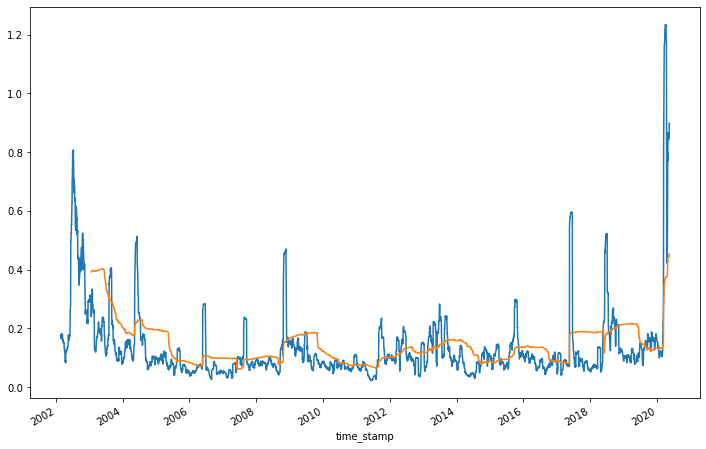

In [17]:
# 252 business days DIs. 21 and 252-days volatility, for observation purpose only
vol21 = ts[252].pct_change().rolling(21).std()*(252**0.5)
vol252 = ts[252].pct_change().rolling(252).std()*(252**0.5)
vol21.plot(figsize=(12,8))
vol252.plot()
plt.show()

## Backtests

In [18]:
# Applies filters to the DI DataFrame

start_date = pd.to_datetime('2010-05-14')
filter_date = df['time_stamp'] >= start_date
filter_oi = df['open_interest_close'] > 150 # At least 150 open_interest
filter_jan = df['maturity_code'].apply(lambda x: x.find('F')>-1) # Contracts with expiry date in January (F)
df2 = df[filter_date & filter_oi & filter_jan][['time_stamp','maturity_date','DU',
                                          'previous_settlement','settlement_price']].dropna()
df2.to_clipboard(excel=True)
df2

,time_stamp,maturity_date,DU,previous_settlement,settlement_price
52903,2010-05-14,2011-01-03,161,93479.56,93506.92
52907,2010-05-14,2012-01-02,412,82739.80,82700.22
52911,2010-05-14,2013-01-02,663,73207.94,73147.93
52915,2010-05-14,2014-01-02,916,65038.95,64899.52
52919,2010-05-14,2015-01-02,1169,57802.13,57642.16
...,...,...,...,...,...
150499,2020-05-15,2026-01-02,1418,66976.28,67163.40
150501,2020-05-15,2027-01-04,1668,60517.49,60752.14
150502,2020-05-15,2028-01-03,1919,54553.74,54699.27
150503,2020-05-15,2029-01-02,2168,49635.17,49684.97


###  Momentum model backtest

<ipython-input-19-0309d7f61a9a>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  backtest = pd.Series(index=calendar)


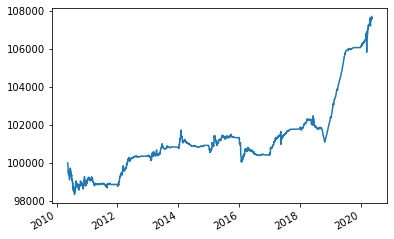

In [19]:
def get_backtest(df,k_order):
    calendar = pd.DatetimeIndex(df['time_stamp'].sort_values().unique())
    start_date = calendar[0]
    curve = df[df['time_stamp']==start_date]
    curve = curve.set_index('maturity_date').drop('time_stamp',1).sort_index()
    contract = curve.index[k_order]
    roll_date = dc.workday(contract,-3) # Rola o contrato 3 dias antes do vencimento
    backtest = pd.Series(index=calendar)
    backtest.iloc[0] = 100000
    quant = backtest.iloc[0]/curve.loc[contract,'settlement_price']

    for d in backtest.index[1:]:
        curve = df[df['time_stamp']==d].set_index('maturity_date').drop('time_stamp',1).sort_index()
        
        if contract not in curve.index:
            backtest[d] = backtest[:d].iloc[-2]
            continue
        
        p0 = curve.loc[contract,'previous_settlement']
        p1 = curve.loc[contract,'settlement_price']
        du = curve.loc[contract,'DU']
        
        v = df_signals[du-1]
        
        if v[v.index==d][0]==0:
            pnl = quant*(p1-p0)   
        else:
            pnl = quant*(p0-p1)
            
        backtest[d] = backtest[:d].iloc[-2] + pnl 

        if d>=roll_date:
            contract = curve.index[k_order]
            roll_date = dc.workday(contract,-3)
            quant = backtest[d]/curve.loc[contract,'settlement_price']
    
    return backtest.astype(float)

backtest = get_backtest(df2,k_order = 1)
backtest.plot()

<ipython-input-19-0309d7f61a9a>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  backtest = pd.Series(index=calendar)


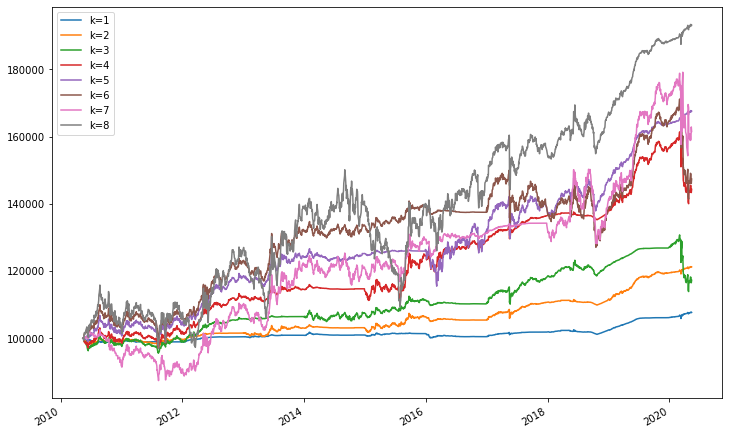

In [20]:
backtests_df = pd.DataFrame()
for k in range(1,9):
    backtest_k = get_backtest(df2, k_order = k)
    backtests_df = pd.concat([backtests_df,backtest_k.to_frame('k=%s' % k)],axis=1)
backtests_df.plot(figsize=(12,8))

                           k=1        k=2        k=3        k=4        k=5  \
frequency                daily      daily      daily      daily      daily   
excess_returns      0.00756918   0.019881  0.0164165  0.0382834  0.0543178   
volatility           0.0075397  0.0195421  0.0416151  0.0524715  0.0653448   
sharpe                 1.00391    1.01734   0.394485   0.729603   0.831248   
sortino                1.12665    1.14987   0.377222   0.795643   0.913261   
maxDD               -0.0165642 -0.0293744  -0.129066  -0.132499 -0.0922639   
maxDD_to_vol_ratio    -2.19694   -1.50314   -3.10143   -2.52517   -1.41196   
from_date            14-May-10  14-May-10  14-May-10  14-May-10  14-May-10   
to_date              15-May-20  15-May-20  15-May-20  15-May-20  15-May-20   
n_obs                     2460       2460       2460       2460       2460   

                          k=6        k=7        k=8  
frequency               daily      daily      daily  
excess_returns      0.0405328  0.

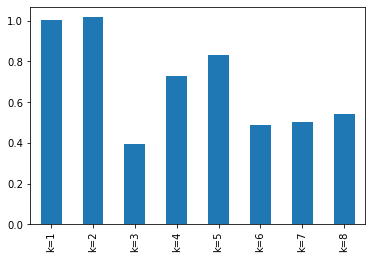

In [21]:
perf_table_m = fhp.get_perf_table(backtests_df.astype(float))
print(perf_table_m)
perf_table_m.loc['sharpe'].plot(kind='bar')

###  Carry stratetgy backtest (long only)

<ipython-input-22-b6d389283f72>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  backtest_carry = pd.Series(index=calendar)


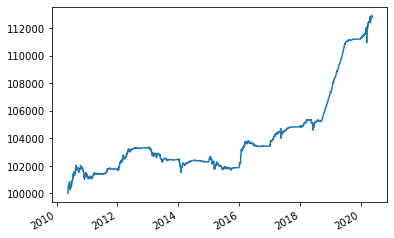

In [22]:
def get_backtest_carry(df,k_order):
    calendar = pd.DatetimeIndex(df['time_stamp'].sort_values().unique())
    start_date = calendar[0]
    curve = df[df['time_stamp']==start_date]
    curve = curve.set_index('maturity_date').drop('time_stamp',1).sort_index()
    contract = curve.index[k_order]
    roll_date = dc.workday(contract,-3)
    backtest_carry = pd.Series(index=calendar)
    backtest_carry.iloc[0] = 100000
    quant = backtest_carry.iloc[0]/curve.loc[contract,'settlement_price']

    for d in backtest_carry.index[1:]:
        curve = df[df['time_stamp']==d].set_index('maturity_date').drop('time_stamp',1).sort_index()
        
        if contract not in curve.index:
            backtest_carry[d] = backtest_carry[:d].iloc[-2]
            continue
        
        p0 = curve.loc[contract,'previous_settlement']
        p1 = curve.loc[contract,'settlement_price']
        
        pnl = quant*(p1-p0)
            
        backtest_carry[d] = backtest_carry[:d].iloc[-2] + pnl 

        if d>=roll_date:
            contract = curve.index[k_order]
            roll_date = dc.workday(contract,-3)
            quant = backtest_carry[d]/curve.loc[contract,'settlement_price']
    
    return backtest_carry.astype(float)

backtest_carry = get_backtest_carry(df2,k_order = 1)
backtest_carry.plot()

<ipython-input-22-b6d389283f72>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  backtest_carry = pd.Series(index=calendar)


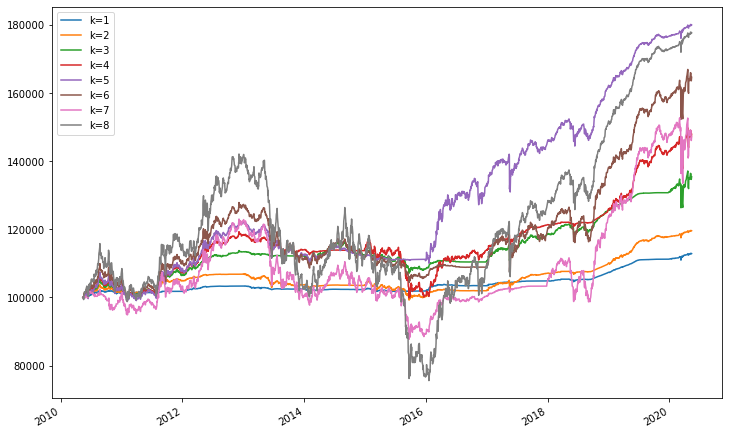

In [23]:
backtests_df_carry = pd.DataFrame()
for k in range(1,9):
    backtest_k_carry = get_backtest_carry(df2, k_order = k)
    backtests_df_carry = pd.concat([backtests_df_carry,backtest_k_carry.to_frame('k=%s' % k)],axis=1)
backtests_df_carry.plot(figsize=(12,8))

                           k=1        k=2        k=3        k=4        k=5  \
frequency                daily      daily      daily      daily      daily   
excess_returns       0.0124623  0.0184775  0.0315537  0.0409193  0.0620666   
volatility          0.00747577  0.0196845  0.0407542  0.0536482   0.059924   
sharpe                 1.66702   0.938682   0.774245   0.762735    1.03576   
sortino                1.79283   0.966926   0.732853   0.804097    1.14643   
maxDD               -0.0176638 -0.0722074 -0.0806576  -0.163257  -0.104688   
maxDD_to_vol_ratio     -2.3628   -3.66824   -1.97913   -3.04311   -1.74701   
from_date            14-May-10  14-May-10  14-May-10  14-May-10  14-May-10   
to_date              15-May-20  15-May-20  15-May-20  15-May-20  15-May-20   
n_obs                     2460       2460       2460       2460       2460   

                          k=6        k=7        k=8  
frequency               daily      daily      daily  
excess_returns       0.052411  0.

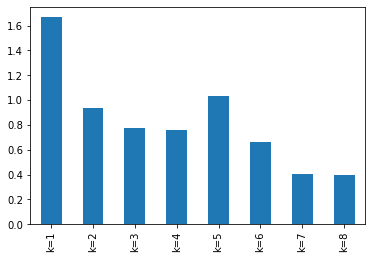

In [24]:
perf_table_carry = fhp.get_perf_table(backtests_df_carry.astype(float))
print(perf_table_carry)
perf_table_carry.loc['sharpe'].plot(kind='bar')

### Carry and momentum strategies backtest

<ipython-input-25-356cb823947a>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  backtest_comp = pd.Series(index=calendar)


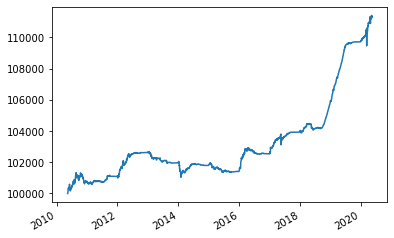

In [25]:
# Combined strategies backtest

def get_backtest_comp(df,k_order):
    calendar = pd.DatetimeIndex(df['time_stamp'].sort_values().unique())
    start_date = calendar[0]
    curve = df[df['time_stamp']==start_date]
    curve = curve.set_index('maturity_date').drop('time_stamp',1).sort_index()
    contract = curve.index[k_order]
    roll_date = dc.workday(contract,-3) # Rola o contrato 3 dias antes do vencimento
    backtest_comp = pd.Series(index=calendar)
    backtest_comp.iloc[0] = 100000
    quant = backtest_comp.iloc[0]/curve.loc[contract,'settlement_price']

    for d in backtest_comp.index[1:]:
        curve = df[df['time_stamp']==d].set_index('maturity_date').drop('time_stamp',1).sort_index()
        
        if contract not in curve.index:
            backtest_comp[d] = backtest_comp[:d].iloc[-2]
            continue
        
        p0 = curve.loc[contract,'previous_settlement']
        p1 = curve.loc[contract,'settlement_price']
        du = curve.loc[contract,'DU']
        
        vol_21 = df_vol.loc[d][du-1]
        vol_252 = df_vol_h.loc[d][du-1]
        
        v = df_signals[du-1]
        
        if v[v.index==d][0]==0:
            pnl = quant*(p1-p0)
        else:
            pnl = quant*(p1-p0)*vol_252/vol_21*0.5
            
        backtest_comp[d] = backtest_comp[:d].iloc[-2] + pnl 

        if d>=roll_date:
            contract = curve.index[k_order]
            roll_date = dc.workday(contract,-3)
            quant = backtest_comp[d]/curve.loc[contract,'settlement_price']
    
    
    if v[v.index==d][0]==0:
            position = 1
    else:
            position = 0.5
    
    return backtest_comp.astype(float)

backtest_comp = get_backtest_comp(df2,k_order = 1)
backtest_comp.plot()

<ipython-input-25-356cb823947a>:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  backtest_comp = pd.Series(index=calendar)


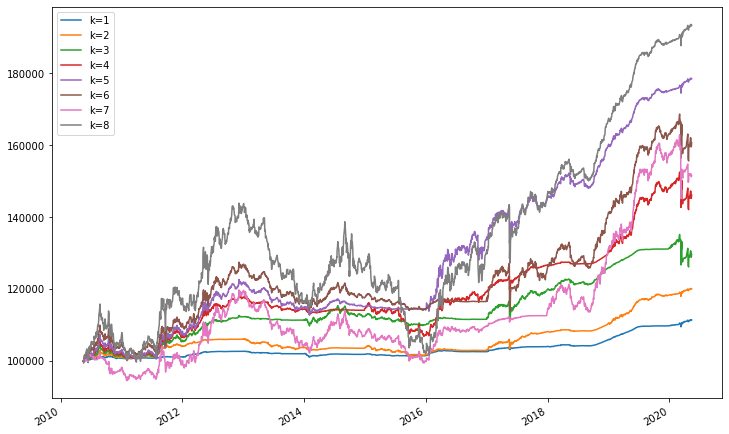

In [26]:
# Combined strategies backtest, daily frequency

backtests_df_comp = pd.DataFrame()
for k in range(1,9):
    backtest_k_comp = get_backtest_comp(df2, k_order = k)
    backtests_df_comp = pd.concat([backtests_df_comp,backtest_k_comp.to_frame('k=%s' % k)],axis=1)
backtests_df_comp.plot(figsize=(12,8))

                           k=1        k=2        k=3        k=4        k=5  \
frequency                daily      daily      daily      daily      daily   
excess_returns       0.0110653  0.0188732  0.0269283  0.0396047  0.0611626   
volatility          0.00640327  0.0154711  0.0362633  0.0446209   0.054409   
sharpe                 1.72807    1.21991   0.742577   0.887581    1.12413   
sortino                1.82178    1.21989   0.658825    0.90224    1.18522   
maxDD               -0.0159076 -0.0445878  -0.066728 -0.0991919 -0.0809814   
maxDD_to_vol_ratio    -2.48429   -2.88201   -1.84009   -2.22299   -1.48838   
from_date            14-May-10  14-May-10  14-May-10  14-May-10  14-May-10   
to_date              15-May-20  15-May-20  15-May-20  15-May-20  15-May-20   
n_obs                     2460       2460       2460       2460       2460   

                          k=6        k=7        k=8  
frequency               daily      daily      daily  
excess_returns       0.049768  0.

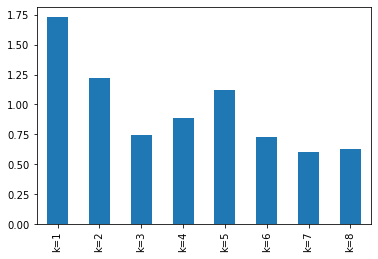

In [27]:
perf_table_comp_d = fhp.get_perf_table(backtests_df_comp.astype(float), freq='daily')
print(perf_table_comp_d)
perf_table_comp_d.loc['sharpe'].plot(kind='bar')

                           k=1         k=2        k=3         k=4        k=5  \
frequency               weekly      weekly     weekly      weekly     weekly   
excess_returns      0.00227335  0.00386564  0.0054982  0.00804691  0.0123253   
volatility          0.00290873  0.00702784  0.0164729   0.0202694  0.0247156   
sharpe                0.781562    0.550046   0.333773    0.396999   0.498683   
sortino               0.823946    0.550039   0.296128    0.403556   0.525785   
maxDD               -0.0159076  -0.0445878  -0.066728  -0.0991919 -0.0809814   
maxDD_to_vol_ratio     -5.4689    -6.34445   -4.05078    -4.89369   -3.27652   
from_date            14-May-10   14-May-10  14-May-10   14-May-10  14-May-10   
to_date              15-May-20   15-May-20  15-May-20   15-May-20  15-May-20   
n_obs                     2460        2460       2460        2460       2460   

                          k=6         k=7        k=8  
frequency              weekly      weekly     weekly  
excess_re

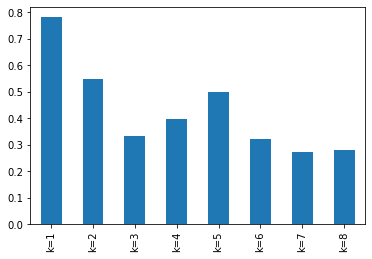

In [28]:
# Combined strategies backtest, weekly frequency

perf_table_comp_w = fhp.get_perf_table(backtests_df_comp.astype(float), freq='weekly')
print(perf_table_comp_w)
perf_table_comp_w.loc['sharpe'].plot(kind='bar')

                            k=1          k=2         k=3         k=4  \
frequency               monthly      monthly     monthly     monthly   
excess_returns      0.000524162  0.000890747  0.00126614  0.00185126   
volatility           0.00139731   0.00337606  0.00791331  0.00973708   
sharpe                 0.375123     0.263842    0.160001    0.190125   
sortino                0.395465     0.263838    0.141956    0.193265   
maxDD                -0.0159076   -0.0445878   -0.066728  -0.0991919   
maxDD_to_vol_ratio     -11.3844      -13.207    -8.43237     -10.187   
from_date             14-May-10    14-May-10   14-May-10   14-May-10   
to_date               15-May-20    15-May-20   15-May-20   15-May-20   
n_obs                      2460         2460        2460        2460   

                           k=5         k=6         k=7         k=8  
frequency              monthly     monthly     monthly     monthly  
excess_returns      0.00283091  0.00231549  0.00202853  0.00322263  


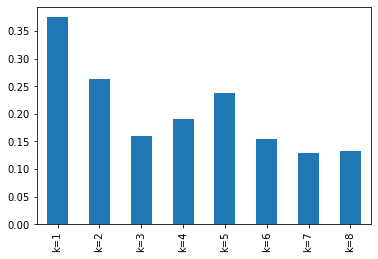

In [29]:
# Combined strategies backtest, monthly frequency

perf_table_comp_m = fhp.get_perf_table(backtests_df_comp.astype(float), freq='monthly')
print(perf_table_comp_m)
perf_table_comp_m.loc['sharpe'].plot(kind='bar')